Load Required Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.18.0
GPU Available: []


Load & Preprocess Images

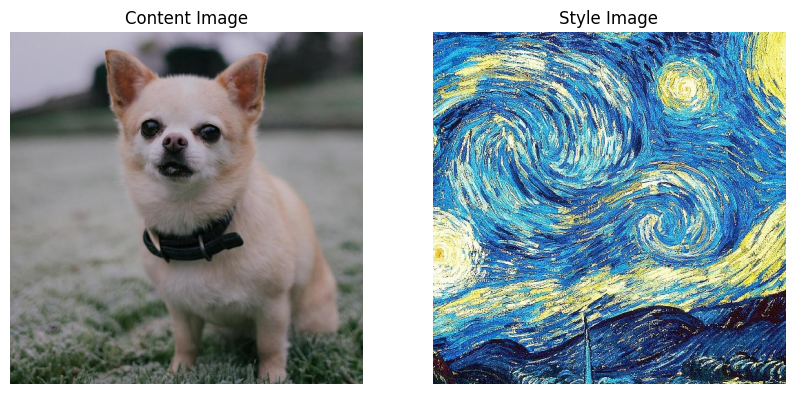

In [3]:
def load_and_process_image(image_path):
    img = load_img(image_path, target_size=(512, 512))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img, dtype=tf.float32)

def deprocess_image(img):
    img = img.numpy().reshape((512, 512, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

# image paths
content_path = "/content/content.jpg"
style_path = "/content/style.jpg"

content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(deprocess_image(content_image))
plt.title("Content Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(deprocess_image(style_image))
plt.title("Style Image")
plt.axis("off")
plt.show()


Load VGG19

In [4]:
def get_vgg_model():
    vgg = vgg19.VGG19(weights="imagenet", include_top=False)
    vgg.trainable = False


    content_layer = "block5_conv2"
    style_layers = [
        "block1_conv1", "block2_conv1", "block3_conv1",
        "block4_conv1", "block5_conv1"
    ]

    outputs = [vgg.get_layer(name).output for name in [content_layer] + style_layers]
    model = Model(inputs=vgg.input, outputs=outputs)
    return model

feature_extractor = get_vgg_model()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extract Feature Representations

In [5]:
def gram_matrix(tensor):
    result = tf.linalg.einsum("bijc,bijd->bcd", tensor, tensor)
    input_shape = tf.shape(tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def get_feature_representations(model, content_image, style_image):
    content_outputs = model(content_image)
    style_outputs = model(style_image)

    content_features = content_outputs[0]
    style_features = content_outputs[1:]

    style_grams = [gram_matrix(style_feature) for style_feature in style_features]

    return content_features, style_grams

content_features, style_grams = get_feature_representations(feature_extractor, content_image, style_image)


Define Loss Function

In [6]:
def compute_loss(model, generated_image, content_features, style_grams):
    generated_outputs = model(generated_image)

    gen_content_features = generated_outputs[0]
    gen_style_features = generated_outputs[1:]

    content_loss = tf.reduce_mean(tf.square(content_features - gen_content_features))

    style_loss = tf.add_n([
        tf.reduce_mean(tf.square(gram_matrix(gen_style_features[i]) - style_grams[i]))
        for i in range(len(style_grams))
    ]) / len(style_grams)

    total_loss = (1e4 * content_loss) + (1e-2 * style_loss)
    return total_loss


Optimize Image

In [7]:
generated_image = tf.Variable(content_image, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = compute_loss(feature_extractor, generated_image, content_features, style_grams)

    gradients = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])

    generated_image.assign(tf.clip_by_value(generated_image, 0, 255))

    return loss


Run Training

In [8]:
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model

# Load the VGG19 model without the top classification layers
vgg = vgg19.VGG19(weights="imagenet", include_top=False)

# Freeze the VGG19 model so that its weights are not updated during training
vgg.trainable = False

# Select layers for content and style extraction
content_layer = "block5_conv2"  # Content layer
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]  # Style layers

# Get the outputs from the selected layers
outputs = [vgg.get_layer(name).output for name in [content_layer] + style_layers]

# Define the model to extract features from the selected layers
model = Model(inputs=vgg.input, outputs=outputs)


Epoch 0: Loss = 0.0
Epoch 2: Loss = 27455456.0
Epoch 4: Loss = 23682664.0
Epoch 6: Loss = 21062840.0
Epoch 8: Loss = 18998692.0
Epoch 10: Loss = 17288142.0
Epoch 12: Loss = 15835585.0
Epoch 14: Loss = 14594309.0
Epoch 16: Loss = 13516504.0
Epoch 18: Loss = 12565830.0
Epoch 20: Loss = 11725892.0
Epoch 22: Loss = 10977076.0
Epoch 24: Loss = 10311302.0
Epoch 26: Loss = 9722463.0
Epoch 28: Loss = 9204790.0
Epoch 30: Loss = 8743993.0
Epoch 32: Loss = 8333312.5
Epoch 34: Loss = 7965454.0
Epoch 36: Loss = 7635281.0
Epoch 38: Loss = 7335546.5
Epoch 40: Loss = 7063893.0
Epoch 42: Loss = 6817425.0
Epoch 44: Loss = 6591673.0
Epoch 46: Loss = 6384249.5
Epoch 48: Loss = 6192954.0
Epoch 50: Loss = 6016355.5
Epoch 52: Loss = 5853530.0
Epoch 54: Loss = 5701613.0
Epoch 56: Loss = 5560182.5
Epoch 58: Loss = 5427809.0
Epoch 60: Loss = 5303846.0
Epoch 62: Loss = 5187308.0
Epoch 64: Loss = 5077202.0
Epoch 66: Loss = 4973605.0
Epoch 68: Loss = 4875593.0
Epoch 70: Loss = 4783406.0
Epoch 72: Loss = 4696184.0


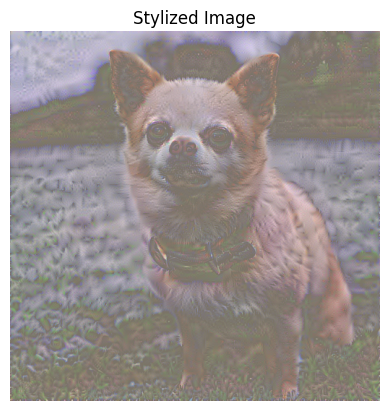

In [9]:
epochs = 200

for epoch in range(epochs):
    loss = train_step()
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy()}")

# Display image every 2 epochs
if epoch % 2 == 0:
    plt.imshow(deprocess_image(generated_image.numpy()))
    plt.axis("off")
    plt.show()


# Display final result
plt.imshow(deprocess_image(generated_image))
plt.title("Stylized Image")
plt.axis("off")
plt.show()
